In [162]:
import torch
import numpy as np
import pickle
from transformers import DecisionTransformerModel
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [163]:
rewardmap_path = '/home/moonlab/Active-sampling-multi-robot-learning/Main/trainingData/gaussian_mixture_training_data.pkl'

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rewardmap = pickle.load(open(rewardmap_path, 'rb'), encoding='latin1')
rewardmap = torch.tensor(rewardmap, dtype=torch.float32).to(device)

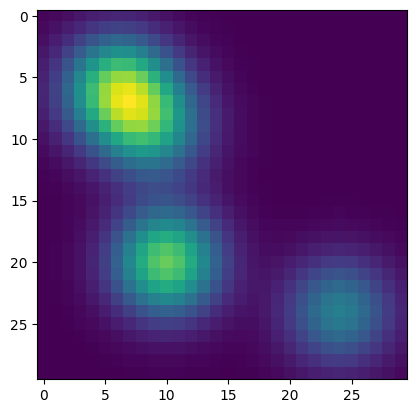

In [165]:
plt.imshow(rewardmap.cpu().numpy())

In [166]:
num_traj = 100 #M
num_robot = 3 #N
comm_range = 5
H = 100
obs_len = 50

In [167]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)
    
    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        loss = torch.mean((action_preds - action_targets) ** 2)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

    

In [168]:
model = torch.load('/home/moonlab/Active-sampling-multi-robot-learning/Main/trained_model.pt').to(device)
model.eval()

TrainableDT(
  (encoder): DecisionTransformerGPT2Model(
    (wte): Embedding(1, 128)
    (wpe): Embedding(1024, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x DecisionTransformerGPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): DecisionTransformerGPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): DecisionTransformerGPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (embed_timestep): Embedding(4096, 128)
  (embed_return): Linear(in_features=1, out_features=128, bias=True)
  (embed_state): Linear(

In [169]:
state_dim = num_robot*2
act_dim = num_robot*2

In [170]:
states = torch.zeros((num_traj, H, state_dim), dtype=torch.float32).to(device)
actions = torch.zeros((num_traj, H, act_dim), dtype=torch.float32).to(device)
rewards = torch.zeros((num_traj, H, 1), dtype=torch.float32).to(device)
returns = torch.zeros((num_traj, H, 1), dtype=torch.float32).to(device)
timesteps = torch.zeros((num_traj, H), dtype=torch.long).to(device)
attention_mask = torch.zeros((num_traj, H), dtype=torch.float32).to(device)

In [171]:
with torch.no_grad():
    preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns,
        timesteps=timesteps,
        attention_mask=attention_mask,
    )

In [207]:
states = torch.zeros((num_traj, H, state_dim), dtype=torch.float32).to(device)
print('ss', states.shape)
actions = torch.zeros((num_traj, H, act_dim), dtype=torch.float32).to(device)
rewards = torch.zeros((num_traj, H, 1), dtype=torch.float32).to(device)
returns = torch.zeros((num_traj, H, 1), dtype=torch.float32).to(device)
timesteps = torch.zeros((num_traj, H), dtype=torch.long).to(device)
attention_mask = torch.zeros((num_traj, H), dtype=torch.float32).to(device)
for i in range(10):
    with torch.no_grad():
        preds = model.original_forward(
            states=states,
            actions=actions,
            rewards=rewards,
            returns_to_go=returns,
            timesteps=timesteps,
            attention_mask=attention_mask,
        )
        print(preds[0][55, :,:])


ss torch.Size([100, 100, 6])
tensor([[-0.1459, -0.0639,  0.2803, -0.1051,  0.2419,  0.1105],
        [-0.1453, -0.0641,  0.2834, -0.1015,  0.2458,  0.1172],
        [-0.1452, -0.0641,  0.2847, -0.1000,  0.2472,  0.1199],
        [-0.1452, -0.0641,  0.2854, -0.0992,  0.2480,  0.1213],
        [-0.1452, -0.0640,  0.2859, -0.0986,  0.2485,  0.1223],
        [-0.1453, -0.0640,  0.2862, -0.0982,  0.2489,  0.1229],
        [-0.1453, -0.0640,  0.2864, -0.0979,  0.2492,  0.1234],
        [-0.1453, -0.0641,  0.2866, -0.0977,  0.2494,  0.1238],
        [-0.1453, -0.0641,  0.2867, -0.0975,  0.2495,  0.1240],
        [-0.1453, -0.0641,  0.2869, -0.0973,  0.2497,  0.1243],
        [-0.1454, -0.0641,  0.2869, -0.0972,  0.2498,  0.1245],
        [-0.1454, -0.0641,  0.2870, -0.0971,  0.2499,  0.1246],
        [-0.1454, -0.0641,  0.2871, -0.0970,  0.2500,  0.1248],
        [-0.1454, -0.0641,  0.2872, -0.0969,  0.2500,  0.1249],
        [-0.1454, -0.0641,  0.2872, -0.0969,  0.2501,  0.1250],
        [-0

In [172]:
action_pred = preds[1]

In [173]:
preds[0][0]

tensor([[-0.1459, -0.0639,  0.2803, -0.1051,  0.2419,  0.1105],
        [-0.1453, -0.0641,  0.2834, -0.1015,  0.2458,  0.1172],
        [-0.1452, -0.0641,  0.2847, -0.1000,  0.2472,  0.1199],
        [-0.1452, -0.0641,  0.2854, -0.0992,  0.2480,  0.1213],
        [-0.1452, -0.0640,  0.2859, -0.0986,  0.2485,  0.1223],
        [-0.1453, -0.0640,  0.2862, -0.0982,  0.2489,  0.1229],
        [-0.1453, -0.0640,  0.2864, -0.0979,  0.2492,  0.1234],
        [-0.1453, -0.0641,  0.2866, -0.0977,  0.2494,  0.1238],
        [-0.1453, -0.0641,  0.2867, -0.0975,  0.2495,  0.1240],
        [-0.1453, -0.0641,  0.2869, -0.0973,  0.2497,  0.1243],
        [-0.1454, -0.0641,  0.2869, -0.0972,  0.2498,  0.1245],
        [-0.1454, -0.0641,  0.2870, -0.0971,  0.2499,  0.1246],
        [-0.1454, -0.0641,  0.2871, -0.0970,  0.2500,  0.1248],
        [-0.1454, -0.0641,  0.2872, -0.0969,  0.2500,  0.1249],
        [-0.1454, -0.0641,  0.2872, -0.0969,  0.2501,  0.1250],
        [-0.1454, -0.0641,  0.2872, -0.0

In [174]:
preds[1][0]

tensor([[-0.0259,  0.0547,  0.0523, -0.0070, -0.0240,  0.0370],
        [-0.0287,  0.0492,  0.0436,  0.0099, -0.0058,  0.0219],
        [-0.0305,  0.0464,  0.0409,  0.0149,  0.0010,  0.0176],
        [-0.0313,  0.0448,  0.0399,  0.0170,  0.0041,  0.0157],
        [-0.0317,  0.0438,  0.0394,  0.0183,  0.0058,  0.0146],
        [-0.0319,  0.0431,  0.0391,  0.0190,  0.0070,  0.0139],
        [-0.0321,  0.0426,  0.0388,  0.0196,  0.0078,  0.0134],
        [-0.0323,  0.0421,  0.0387,  0.0203,  0.0086,  0.0131],
        [-0.0325,  0.0417,  0.0385,  0.0208,  0.0092,  0.0129],
        [-0.0326,  0.0415,  0.0384,  0.0212,  0.0095,  0.0128],
        [-0.0328,  0.0413,  0.0383,  0.0216,  0.0098,  0.0126],
        [-0.0328,  0.0411,  0.0383,  0.0219,  0.0101,  0.0125],
        [-0.0329,  0.0409,  0.0382,  0.0221,  0.0103,  0.0124],
        [-0.0330,  0.0408,  0.0382,  0.0224,  0.0104,  0.0124],
        [-0.0331,  0.0407,  0.0381,  0.0225,  0.0106,  0.0123],
        [-0.0331,  0.0406,  0.0381,  0.0

In [175]:
action_pred = action_pred.reshape(num_traj, H, num_robot, 2)

In [176]:
action_pred

tensor([[[[-0.0259,  0.0547],
          [ 0.0523, -0.0070],
          [-0.0240,  0.0370]],

         [[-0.0287,  0.0492],
          [ 0.0436,  0.0099],
          [-0.0058,  0.0219]],

         [[-0.0305,  0.0464],
          [ 0.0409,  0.0149],
          [ 0.0010,  0.0176]],

         ...,

         [[-0.0337,  0.0392],
          [ 0.0381,  0.0241],
          [ 0.0121,  0.0116]],

         [[-0.0337,  0.0391],
          [ 0.0381,  0.0241],
          [ 0.0121,  0.0116]],

         [[-0.0337,  0.0391],
          [ 0.0381,  0.0241],
          [ 0.0121,  0.0116]]],


        [[[-0.0259,  0.0547],
          [ 0.0523, -0.0070],
          [-0.0240,  0.0370]],

         [[-0.0287,  0.0492],
          [ 0.0436,  0.0099],
          [-0.0058,  0.0219]],

         [[-0.0305,  0.0464],
          [ 0.0409,  0.0149],
          [ 0.0010,  0.0176]],

         ...,

         [[-0.0337,  0.0392],
          [ 0.0381,  0.0241],
          [ 0.0121,  0.0116]],

         [[-0.0337,  0.0391],
          [ 0.0381

In [177]:
states = torch.zeros((num_traj, H, num_robot, 2), dtype=torch.float32).to(device)

In [178]:
states[:, 0, :, :] = torch.tensor([[0, 0], [0, 0], [0, 0]], dtype=torch.float32).to(device)

In [179]:
#Update other values of states with the predicted actions
for t in range(1, H):
    states[:, t, :, :] = states[:, t-1, :, :] + action_pred[:, t-1, :, :]

In [180]:
states

tensor([[[[ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00]],

         [[-2.5923e-02,  5.4656e-02],
          [ 5.2347e-02, -7.0425e-03],
          [-2.3989e-02,  3.6986e-02]],

         [[-5.4632e-02,  1.0386e-01],
          [ 9.5985e-02,  2.9031e-03],
          [-2.9774e-02,  5.8866e-02]],

         ...,

         [[-3.2254e+00,  3.8949e+00],
          [ 3.7219e+00,  2.2173e+00],
          [ 1.0392e+00,  1.2006e+00]],

         [[-3.2591e+00,  3.9340e+00],
          [ 3.7600e+00,  2.2415e+00],
          [ 1.0513e+00,  1.2122e+00]],

         [[-3.2927e+00,  3.9732e+00],
          [ 3.7980e+00,  2.2656e+00],
          [ 1.0633e+00,  1.2238e+00]]],


        [[[ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00]],

         [[-2.5923e-02,  5.4656e-02],
          [ 5.2347e-02, -7.0425e-03],
          [-2.3989e-02,  3.6986e-02]],

         [[-5.4632e-02,  1.0386e-01],
          [ 9.598

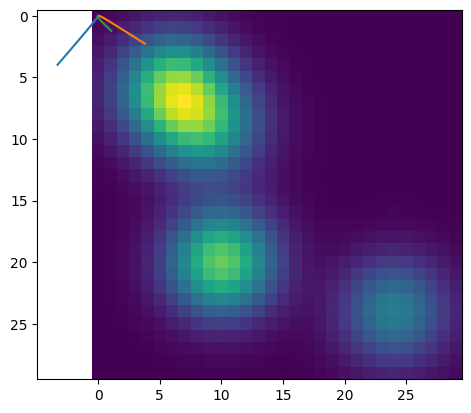

In [181]:
def plot_traj(states, rewardmap, num_robot):
    # for j in range(num_traj):
    plt.imshow(rewardmap.cpu().numpy())
    for i in range(num_robot):
        plt.plot(states[0, :, i, 0].cpu().numpy(), states[0, :, i, 1].cpu().numpy())
    plt.show()

plot_traj(states, rewardmap, num_robot)

/tmp/ipykernel_89422/3577801486.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  anim_robot_list[robot_index].set_data(world_pos[i, robot_index, 0], world_pos[i, robot_index, 1])
/tmp/ipykernel_89422/3577801486.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  anim_robot_list[robot_index].set_data(world_pos[i, robot_index, 0], world_pos[i, robot_index, 1])
/tmp/ipykernel_89422/3577801486.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  anim_robot_list[robot_index].set_data(world_pos[i, robot_index, 0], world_pos[i, robot_index, 1])
/tmp/ipykernel_89422/3577801486.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later


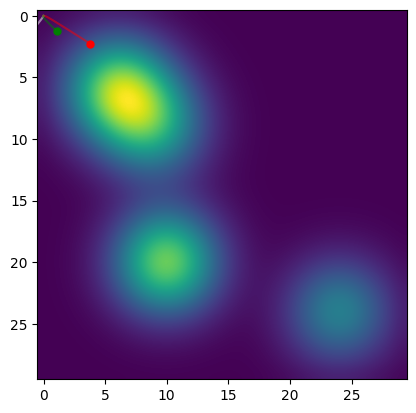

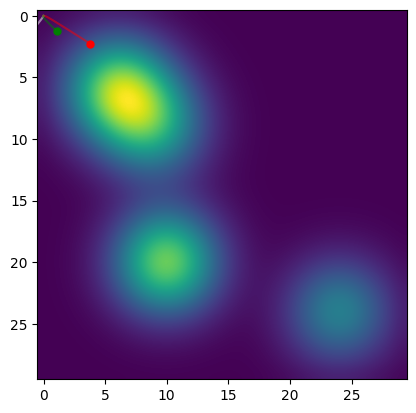

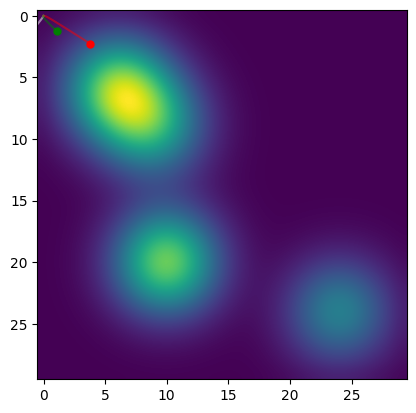

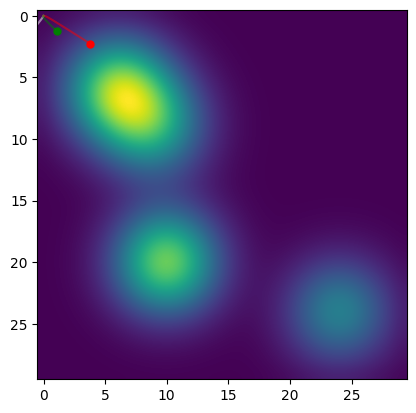

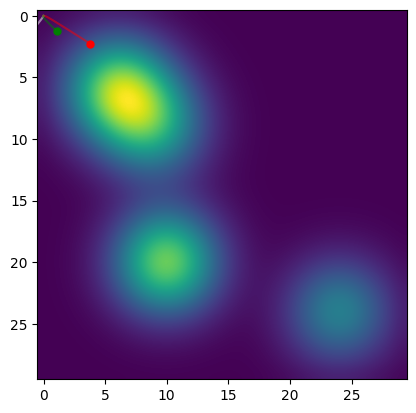

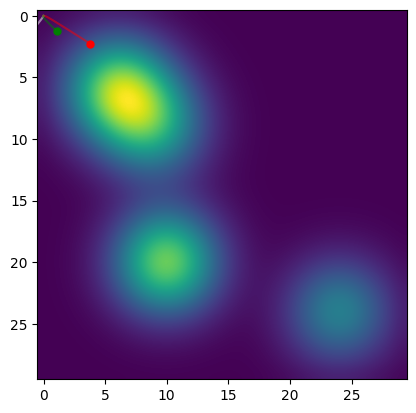

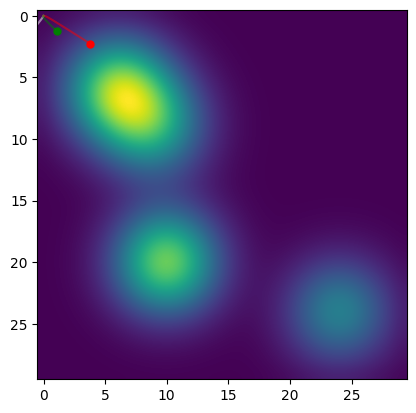

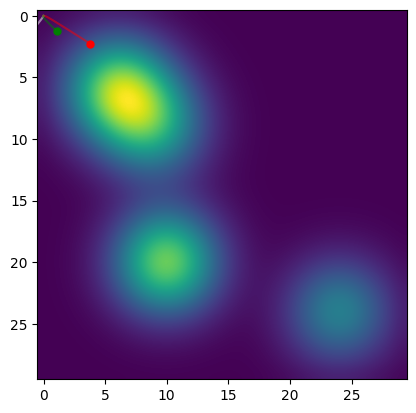

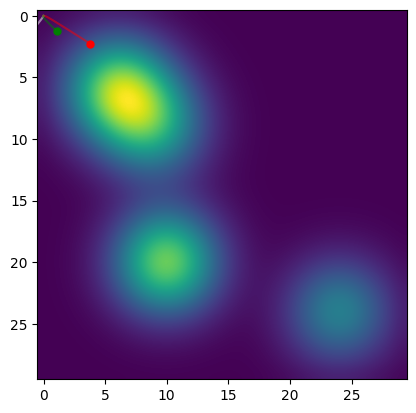

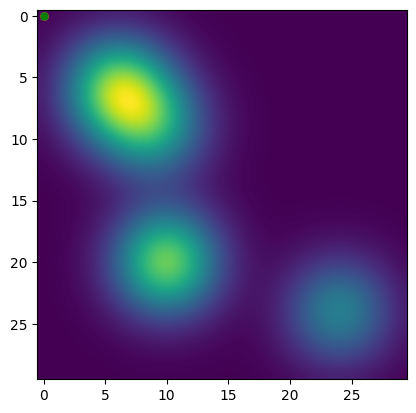

In [182]:
color_list = ['white', 'r', 'g', 'k', 'w', 'm', 'b', 'c', 'darkorange', 'lime',
            'gold', 'lightcyan', 'teal', 'skyblue', 'steelblue', 'pink', 'purple', 'navy', 'azure', 'silver']
for i in range(num_traj-90):
        map = rewardmap.cpu().numpy()
        pos = states[i].cpu().numpy()
        world_pos = np.copy(pos)
        fig, ax = plt.subplots()
        anim_traj_list = []
        anim_robot_list = []
        for robot_index in range(num_robot):
                # create current position plot slot
                anim_robot_list.append(ax.plot(world_pos[0, robot_index, 0], world_pos[0, robot_index, 1], color=color_list[robot_index],
                                       linestyle='None', marker='o', markersize=5)[0])
                anim_traj_list.append(ax.plot([], [], color=color_list[robot_index], alpha=0.5)[0])
        m = ax.imshow(map,cmap='viridis',interpolation='spline36')
        def animation_function(i):
                for robot_index in range(num_robot):
                    # update current position
                    anim_robot_list[robot_index].set_data(world_pos[i, robot_index, 0], world_pos[i, robot_index, 1])
                    # update traj for each agent
                    anim_traj_list[robot_index].set_data(world_pos[:i+1, robot_index, 0], world_pos[:i+1, robot_index, 1])
                return anim_robot_list + anim_traj_list
        anim = animation.FuncAnimation(fig, func=animation_function, frames=len(world_pos))
        save_path = 'animation' + str(i) + '.mp4'
        anim.save("/home/moonlab/Active-sampling-multi-robot-learning/Main/dt_anime/"+save_path, writer=animation.FFMpegWriter(fps=5))


DT INFERENCE

In [183]:
# from transformers import DecisionTransformerConfig, DecisionTransformerModel

In [184]:
# configuration = DecisionTransformerConfig(
#     state_dim = num_robot*2,
#     act_dim = num_robot*2,
#     # max_ep_len=H,
#     # n_positions=H,
#     # n_head=4,
# )

# model = DecisionTransformerModel(configuration)
# model.to(device)

In [185]:
# states = states.to(torch.float32).to(device)
# actions = actions.to(torch.float32).to(device)
# rewards = rewards.to(torch.float32).to(device)
# returns = returns.to(torch.float32).to(device)
# timesteps = timesteps1.long().to(device)
# print(states.device, actions.device, rewards.device, returns.device, timesteps.device)
# # make attention mask
# mask = torch.zeros(num_traj, H, dtype=torch.float64).to(device)
# mask.shape

In [186]:
# states.shape, actions.shape, rewards.shape, returns.shape, timesteps.shape,
# mask.shape

In [187]:
# states.device, actions.device, rewards.device, returns.device, timesteps.device

In [188]:
# import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [189]:
# with torch.no_grad():
#     output = model(
#         states=states,
#         actions=actions,
#         rewards=rewards,
#         returns_to_go=returns,
#         timesteps=timesteps,
#         attention_mask=mask
#     )
#     action_loss = F.mse_loss(output[1], actions)
#     print(action_loss)
#     reward_loss = F.mse_loss(output[2], rewards)
#     print(reward_loss)

# #Send data in batches of 100
# # b = 50
# # predictions = []
# # for i in range(0, num_traj*H, b):
# # # while i < num_traj*H:
# #     with torch.no_grad():
# #         output = model(
# #             states=states[i:i+b],
# #             actions=actions[i:i+b],
# #             rewards=rewards[i:i+b],
# #             returns_to_go=returns[i:i+b],
# #             timesteps=timesteps[i:i+b],
# #             attention_mask=mask[i:i+b]
# #         )
# #         action_loss = F.mse_loss(output[1], actions[i:i+b])
# #         print(action_loss)
# #         reward_loss = F.mse_loss(output[2], rewards[i:i+b])
# #         print(reward_loss)
# #         # i += b
# #     predictions.append(output)
        

In [190]:
# type(output)

In [191]:
# print("State_pred shape: ", output[0].shape, "\nAction_pred shape: ", output[1].shape, "\nReturn_pred shape: ", output[2].shape)

In [192]:
# output[2].shape


In [193]:
# predictions

In [194]:
torch.cuda.empty_cache()